In [104]:
#Import the Need packages
import pandas as pd
import datetime as dt
import numpy as np

In [105]:
#Import the Scrapped news stories
forbes = pd.read_csv(r"I:\python_file\save\M4 (1)\Real Scrapper\Forbes.csv", index_col=0)
ft = pd.read_csv(r"I:\python_file\save\M4 (1)\Real Scrapper\ft.csv", index_col=0)
market = pd.read_csv(r'I:\python_file\save\M4 (1)\Real Scrapper\MarketWatch(nodub).csv', index_col=0)

#Define Column names
col_names = ['Headline', 'Date', 'Description']
col_names1 = ['Headline', 'Date']

#Make alle the columns have the same names
forbes.columns = col_names
ft.columns = col_names
market.columns = col_names1

#Remove HTML char from description
import re
ft['Description'] = ft['Description'].apply(lambda x: re.sub('<[^>]+>', '', x))

#Remove space before headline
market.Headline = market.Headline.str.strip()

#How many stories is there from each 
print(forbes.shape[0])
print(ft.shape[0])
print(market.shape[0])

2487
1818
2439


In [122]:
#Combine the news data into one dataframe
news = pd.concat([forbes, ft, market], ignore_index=True)
news['Date'] = pd.to_datetime(news.Date)

#import the stock dates
stock_df = pd.read_csv("I:\python_file\save\M4 (1)\Stock data\Phizer.csv")
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_date = pd.DataFrame(stock_df['Date'])

#Change news date to last stock date
#news.Date = news.Date.apply(lambda x: min(stock_date.Date[stock_date.Date > x]) if len(stock_date.Date[stock_date.Date > x]) != 0 else np.nan)
news.Date = news.Date.apply(lambda x: max(stock_date.Date[stock_date.Date < x]) if len(stock_date.Date[stock_date.Date < x]) != 0 else np.nan)

#Fill nan with nothing!
news.Description = news.Description.fillna("")

# combine the title and the content to get one dataframe column
news['combined_text'] = news['Headline'].map(str) +" "+ news['Description'].map(str) 
news.sort_values(by=['Date'])


,Headline,Date,Description,combined_text
2486,Pharma Heads Write To Congress... And Put Foot...,2017-02-24,Our tax system is a mess. High taxes put us at...,Pharma Heads Write To Congress... And Put Foot...
2485,How To Trade The 8 'Dogs Of The Dow',2017-03-01,The Dogs of the Dow lag the average on weakne...,How To Trade The 8 'Dogs Of The Dow' The Dogs ...
2484,Alzheimer's Staggering $259B Cost Could Break ...,2017-03-06,The cost of providing care for Americans with ...,Alzheimer's Staggering $259B Cost Could Break ...
2483,What 'Sunday Morning' Didn't Say About How Ani...,2017-03-10,The CBS show 'Sunday Morning' featured dogs an...,What 'Sunday Morning' Didn't Say About How Ani...
2482,Of Abundance And Scarcity In Venture Capital,2017-03-10,Although venture capital is viewed as one asse...,Of Abundance And Scarcity In Venture Capital A...
...,...,...,...,...
4300,Two Pfizer doses give 70% protection against h...,2021-12-14,Two Pfizer doses give 70% protection against h...,Two Pfizer doses give 70% protection against h...
4301,Pfizer says Covid drug offers strong protectio...,2021-12-14,Pfizer says Covid drug offers strong protectio...,Pfizer says Covid drug offers strong protectio...
4302,Episode 51,2021-12-14,3 min listen,Episode 51 3 min listen
4304,FirstFT: China reports first Omicron Covid cases,2021-12-14,"...the country’s 1.4bn people.Meanwhile, two d...",FirstFT: China reports first Omicron Covid cas...


# EDA

# Sentiment

First we try to see the sentiment of the news headlines about Pfizer. For this we use the NLTK package: SentimentIntensityAnalyzer (SIA) which is an pre-trained NLTK-package to determine sentiment of text.

pd.concat

In [107]:
#Importing nltk packages to use SentimentIntensityAnalyzer to determine the Sentiment Analyzis
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nixo_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [108]:
# calculating the polarity of the news articles 
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for line in news['combined_text'] :
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

In [109]:
# Creating a new dataframe of only the polarity score, the headline and the source of the news 
headlines_polarity = pd.DataFrame.from_records(results)
temp = []
for line in news['combined_text'] :
    temp.append(line)
headlines_polarity['headline'] =temp

In [110]:
# categorize news as positive or negative based on the compound score obtained
headlines_polarity['label'] = 0
# I have considered the news as positive if the compound score is greater than 0.2 hence the label 1
headlines_polarity.loc[headlines_polarity['compound'] > 0.2, 'label'] = 1
# if the compound score is below -0.2 then it is considered negative 
headlines_polarity.loc[headlines_polarity['compound'] < -0.2, 'label'] = -1
# word count of news headlines is calculated
headlines_polarity['word_count'] = headlines_polarity['headline'].apply(lambda x: len(str(x).split()))

Here SIA calculates how much the headline is negative, positive and neutral. It gives a compound-score. If the compound-score is:

* Compound-score > 0.2 = 1 (positive)
* Compound-score < -0.2 = -1 (negative)
* Compound-score > -0.2 & <0.2 = 0 (neutral)

In [111]:
news_sentiment = pd.concat([headlines_polarity, news['Date']],axis=1)
news_sentiment.head(2)

,neg,neu,pos,compound,headline,label,word_count,Date
0,0.138,0.682,0.181,0.2263,Pfizer Shot Just 33% Effective Against Omicron...,1,36,2021-12-13
1,0.135,0.782,0.084,-0.2263,New Data Confirms Covid Antiviral Drug 89% Eff...,-1,33,2021-12-13


In [112]:
#Printing some of the headlines from the articles:
print(news['combined_text'][0]) 
print(news['combined_text'][1]) 
print(news['combined_text'][3]) 
print(news['combined_text'][4]) 
print(news['combined_text'][5]) 
print(news['combined_text'][6]) 

Pfizer Shot Just 33% Effective Against Omicron Infection, But Largely Prevents Severe Disease, South Africa Study Finds The preliminary findings suggest a big drop in protection against infection with omicron but strong (70%) protection against hospitalization. 
New Data Confirms Covid Antiviral Drug 89% Effective At Preventing Hospitalizations And Death, Pfizer Says The pharmaceutical giant says new data from its Phase 2/3 studies a previous analysis of the drug's effectiveness.
Dow Drops More Than 300 Points Ahead Of Fed Meeting, Tesla Sinks While Pfizer, Moderna Jump The market moved lower ahead of a key central bank meeting later this week.
Harley-Davidson And A Grocery Tycoon Headline A $15 Billion Spate Of SPAC Mergers Harley-Davidson is spinning off its electric motorcycle arm through a SPAC deal, Pfizer is putting its soaring profits to work in M&A and more from the day in deals. 
In The Face Of An Imminent Omicron Wave, Public Health Officials Seek To Optimize Timing Of Covid-

In [113]:
#See how many 1=positiv, -1=negativ and 0=neutral there is:
headlines_polarity.groupby('label').count()

,neg,neu,pos,compound,headline,word_count
label,,,,,,
-1,1146,1146,1146,1146,1146,1146
0,2723,2723,2723,2723,2723,2723
1,2875,2875,2875,2875,2875,2875


In [114]:
print(headlines_polarity.count())
print(811/4926*100)
print(2025/4926*100)
print(2090/4926*100)
print(16.5+41.1+42.4)

neg           6744
neu           6744
pos           6744
compound      6744
headline      6744
label         6744
word_count    6744
dtype: int64
16.463662200568415
41.10840438489647
42.42793341453512
100.0


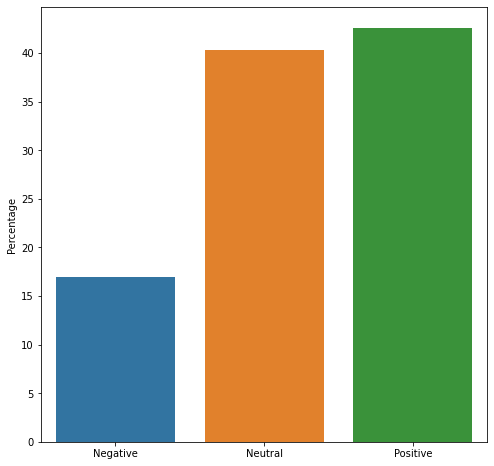

In [115]:
#Importing packages and labeling the news. The labeling is illustrated above this code, for further information.
import matplotlib.pyplot as plt
import seaborn as sns
#Plotting the model
fig, ax = plt.subplots(figsize=(8, 8))
counts = headlines_polarity.label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

In [116]:
#pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

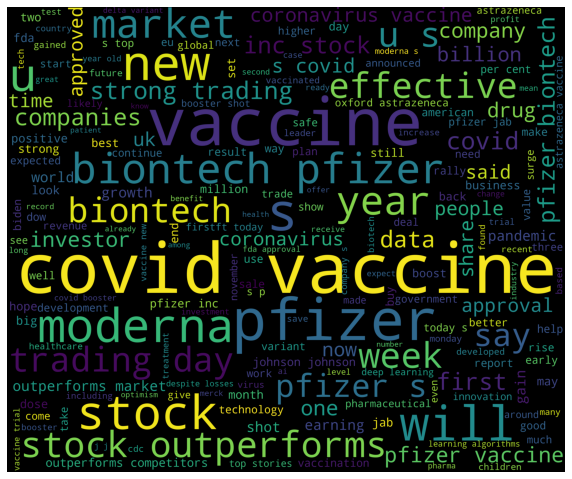

In [117]:
#Most common words in positive sentiment
wordcloud_df=headlines_polarity[headlines_polarity['label']==1]
words = ' '.join(wordcloud_df['headline'])
cleaned_word = " ".join([word for word in words.lower().split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

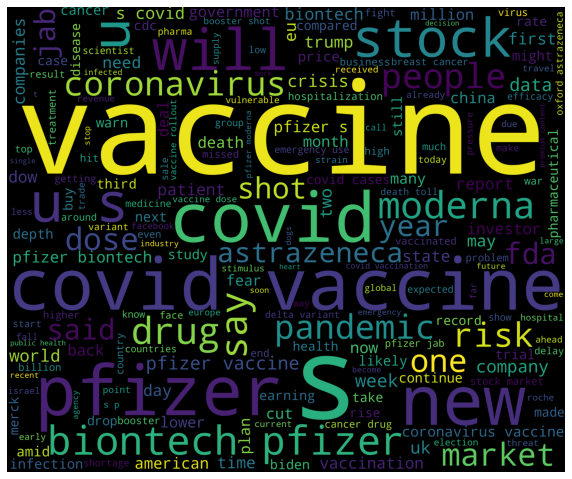

In [118]:
#Most common words in negative sentiment
wordcloud_df=headlines_polarity[headlines_polarity['label']==-1]
words = ' '.join(wordcloud_df['headline'])
cleaned_word = " ".join([word for word in words.lower().split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Label Count

In [119]:
# Creating new dataframes for the where the count of label 1, 0 and -1 respectively are counted on the dates:
label_1=news_sentiment[news_sentiment['label'] == 1].groupby('Date').size()
pd.DataFrame(label_1)
label_0=news_sentiment[news_sentiment['label'] == 0].groupby('Date').size()
pd.DataFrame(label_0)
label_minus=news_sentiment[news_sentiment['label'] == -1].groupby('Date').size()
pd.DataFrame(label_minus)

# Dropping the datetime index, so it's easy to merge with the news dataframe
label_1 = label_1.reset_index(drop=False)
label_0 = label_0.reset_index(drop=False)
label_minus = label_minus.reset_index(drop=False)

# Merging the 3 label-dataframes into one:
k=label_1.merge(label_0, how='left', on='Date')
label_count=k.merge(label_minus, how='left', on='Date')
label_count.columns=['Date','positiv', 'neutral', 'negativ']
label_count=label_count.fillna(0)

In [120]:
#save the labels as a CSV
label_count.to_csv(r"I:\python_file\save\M4 (1)\Sentiment Analysis\News_combined.csv")

In [121]:
#save the raw sentiments as a CSV
news_sentiment1 = news_sentiment.groupby('Date').mean()
news_sentiment1 = news_sentiment1.drop(['label','word_count'], axis=1)
news_sentiment1.to_csv(r"I:\python_file\save\M4 (1)\Sentiment Analysis\news_raw_sent.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=520f7743-fdb5-41d4-ba65-deb67c6338e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>